# Data Engineering - assignment 4

*Matthew Pecsok* 9/18/2024 - Completed by *NekoShiro*



# Overview:

## Generate business value by pulling business review information from APIs and using an LLM model to extract important information from the review data.


## Objectives: Extract user review data from google mapis api with the goal of extracting structured information from it.

## Set up the API access to Google Maps
## Set up access to Meta LLama Model via Hugging Face
## Call the maps API for a business.
## Extract structured information from the review with the LLM.
## Populate a DataFrame with the information gleaned from the reviews.
## Populate a database with the enriched data.

## Task 0: Setups - Google Maps

### Proof that I created Google Places API and Hugging faces account with the access to the model

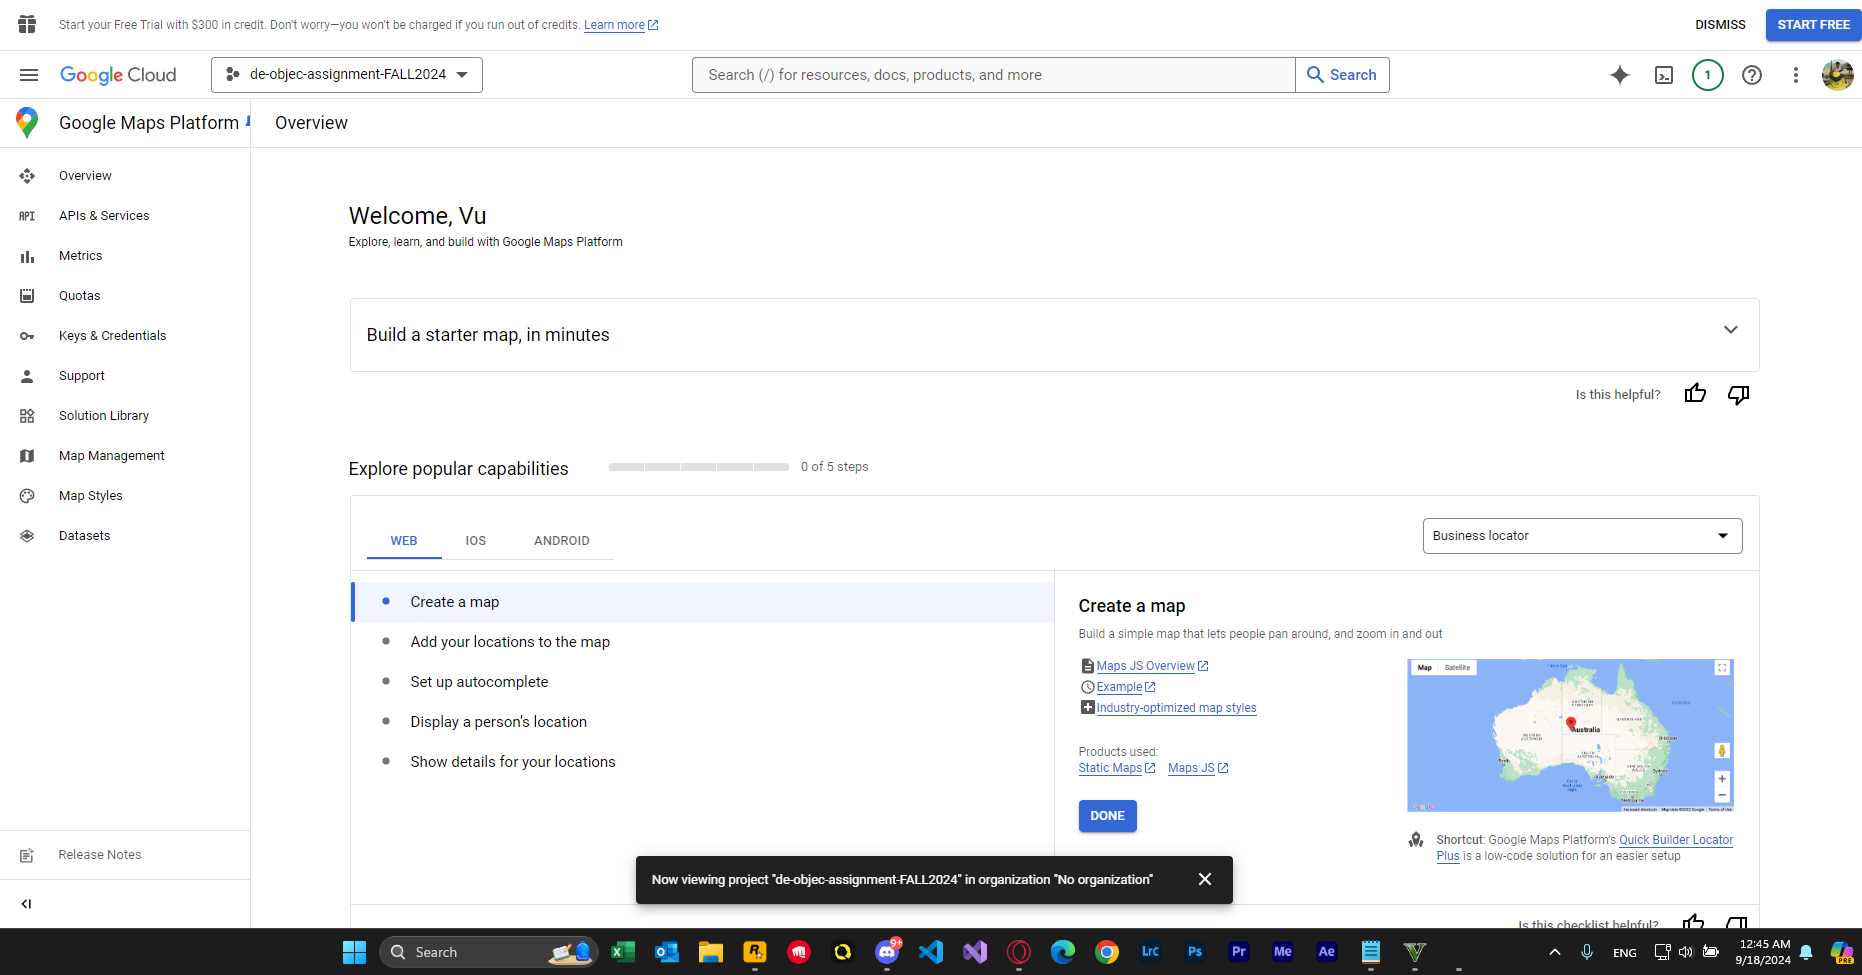

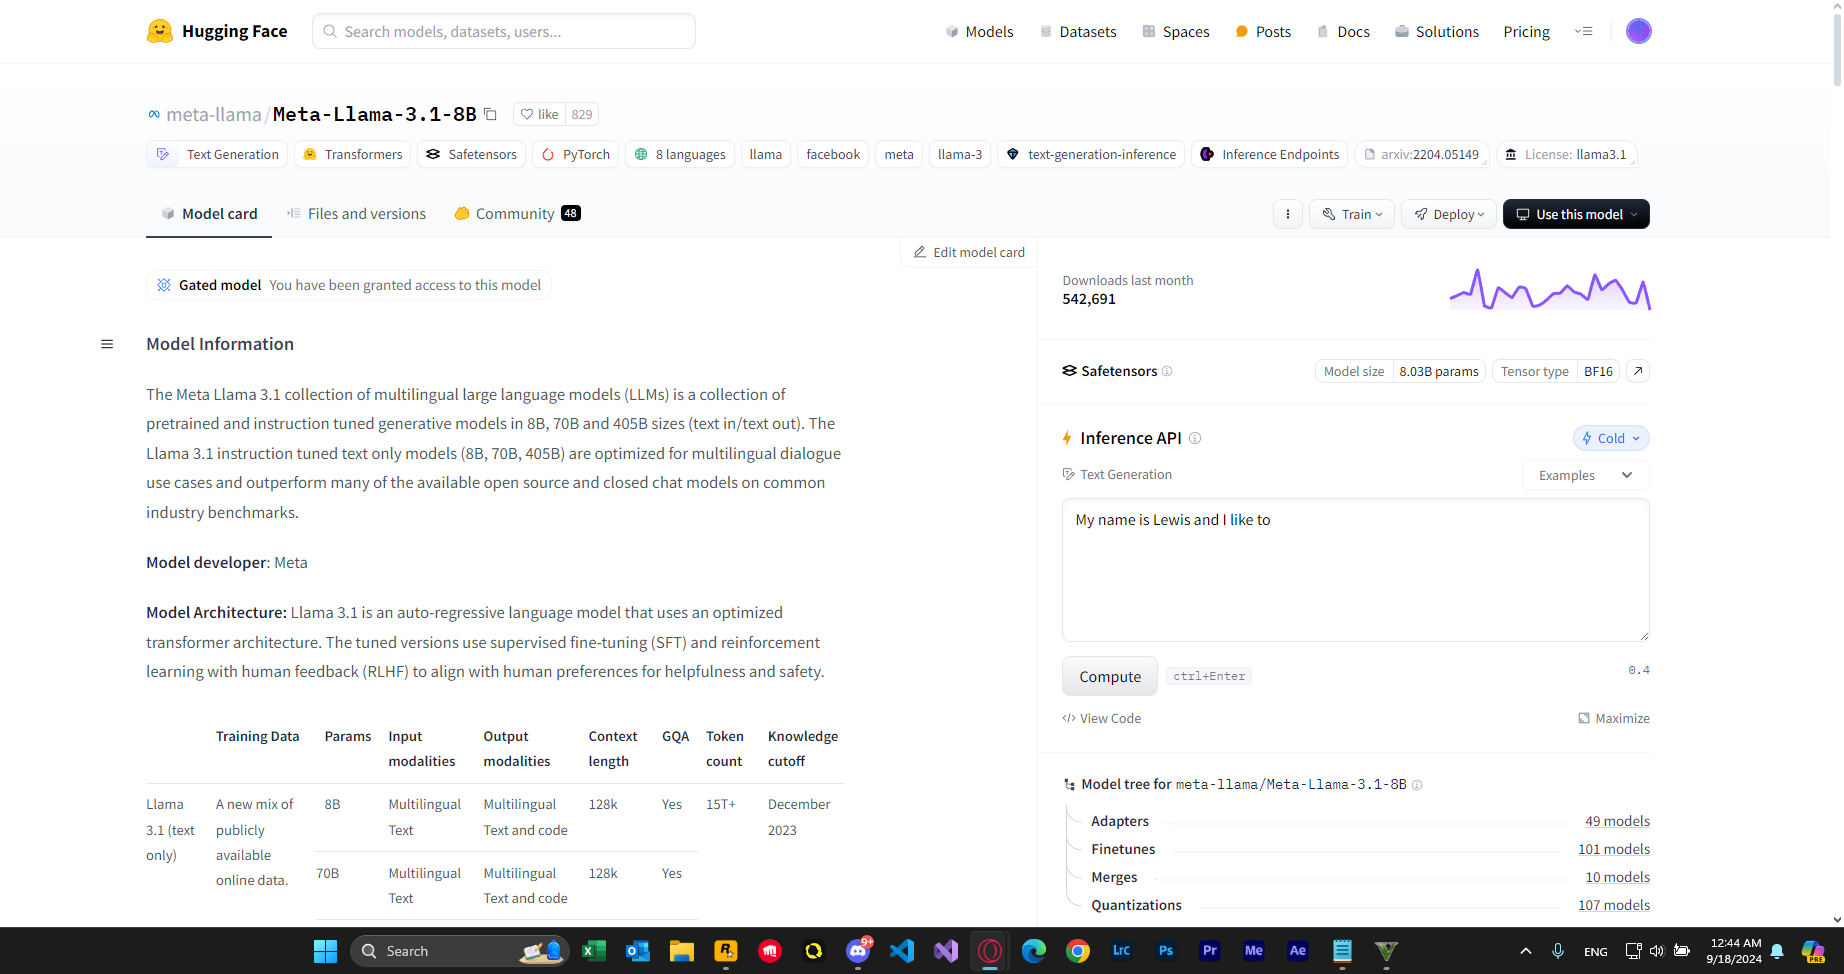

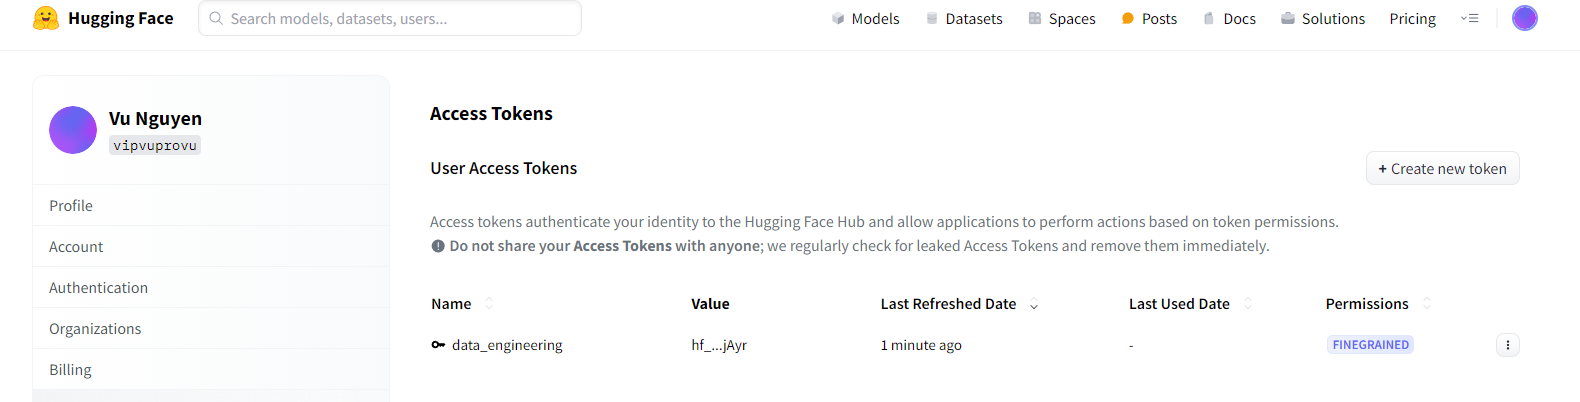

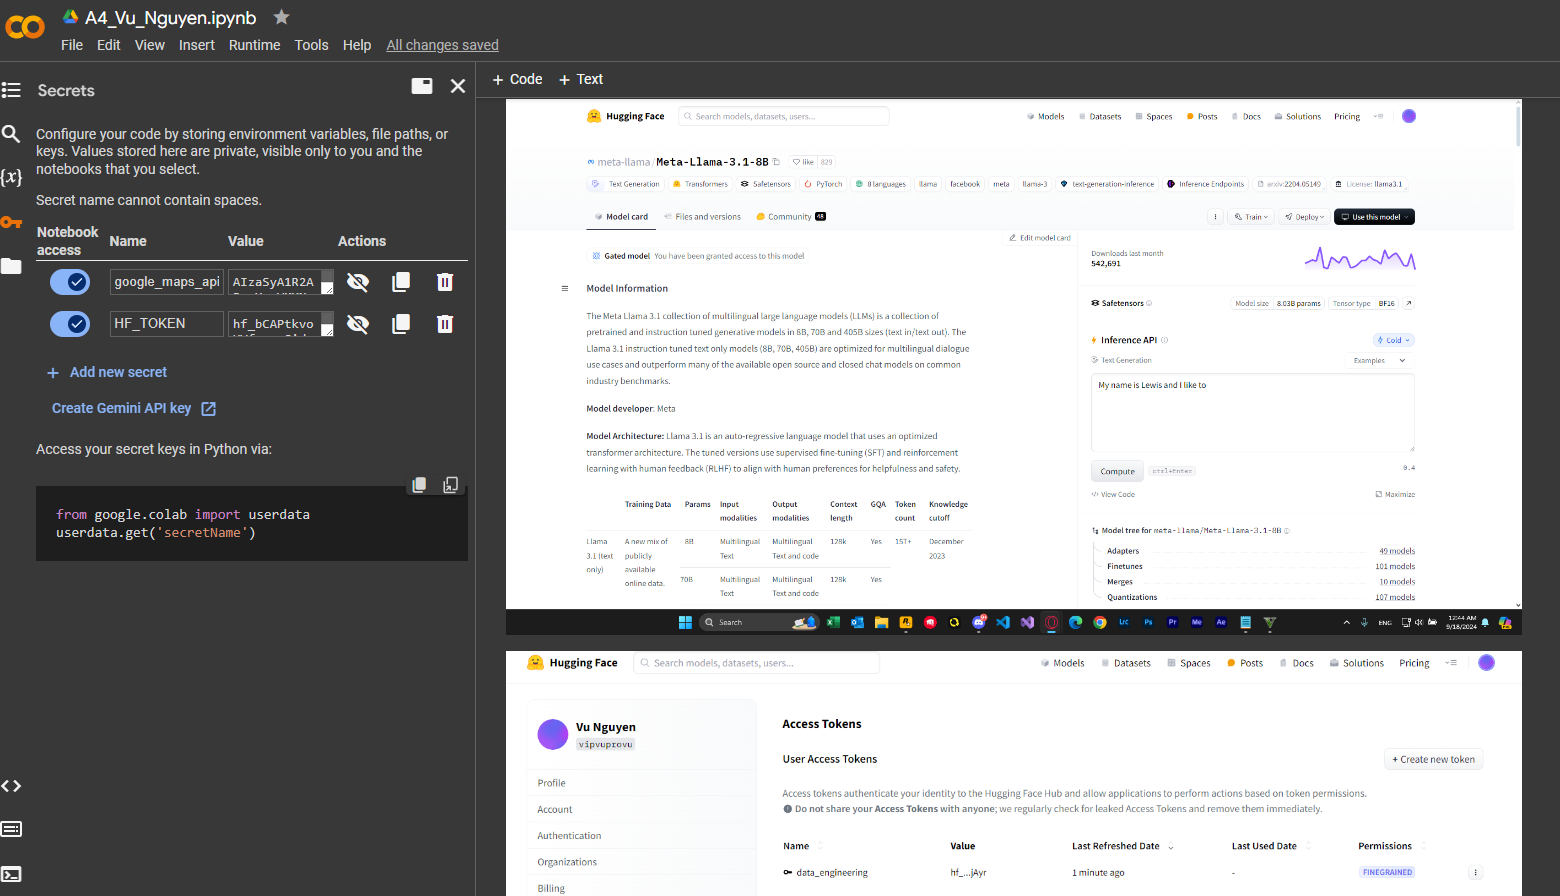

## Database setups (modify with the database requirements from the assignment)

In [1]:
# mount google drive and export your work
from google.colab import drive
drive.mount('/content/drive')
# import library
import os
import sqlite3
import pandas as pd
from google.cloud import storage
from tqdm import tqdm
import duckdb

!pip -q install --upgrade ipython
!pip -q install --upgrade ipython-sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.27.0 which is incompatible.


In [2]:
# setups including getting the database
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/drive/MyDrive/ColabNotebooks/de-objec-assignment-fall2024-924a25eba5a9.json"
GCP_PROJECT = 'de-object-assignment-fall2024' # set project variable
STORAGE_BUCKET = 'customer-transformations-data-fall2024' # set bucket storage
import requests

In [3]:
from google.colab import userdata
API_KEY = userdata.get('google_maps_api')

In [4]:
# Hugging Face Setups
import torch
from transformers import pipeline

HF_TOKEN = userdata.get('HF_TOKEN') # Your token must be in this secret.

pipe = pipeline("text-generation", "meta-llama/Meta-Llama-3-8B-Instruct", torch_dtype=torch.bfloat16, device_map="auto",token=HF_TOKEN)

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

## Task I - Complete Hugging Face and Google Places API setups (10%)


## Prove you can call the Google Places API with the provided code

In [5]:
# Define the business name. This is the name of the business we will identify with the findplace endpoint.
BUSINESS_NAME = 'sweetaly gelato fifteenth and fifteenth utah'

In [6]:
# Use the findplace api endpoint

# We need to identify the place_id of the given business. we'll use the findplace endpoint to learn the unique identifier for the business.

# Note using common name may return multiple candidate places, we'll assume the first one is the correct business.

# We use a get request and the url with the business name and api key

# We take the response and extract the json data from it

find_place_url = f"https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input={BUSINESS_NAME}&inputtype=textquery&key={API_KEY}"
response = requests.get(find_place_url)
json_response = response.json()
json_response

{'candidates': [{'place_id': 'ChIJ41C4NARgUocRPkliM-EwBXw'}], 'status': 'OK'}

In [7]:
# get the list of candidates from the dictionary key 'candidates'. if candidates isn't found return an empty list.
candidates = json_response.get('candidates', [])
candidates

[{'place_id': 'ChIJ41C4NARgUocRPkliM-EwBXw'}]

In [8]:
# return '' if we cannot find the place id key. assume the 1st element is the one we want.
place_id = candidates[0].get('place_id','')
place_id

'ChIJ41C4NARgUocRPkliM-EwBXw'

In [9]:
# Retrieve Business Reviews
details_url = f"https://maps.googleapis.com/maps/api/place/details/json?place_id={place_id}&fields=reviews&key={API_KEY}"
response = requests.get(details_url)
reviews = response.json().get('result', {}).get('reviews', [])

In [10]:
reviews

[{'author_name': 'Jeremy Peters',
  'author_url': 'https://www.google.com/maps/contrib/118110536576238973697/reviews',
  'language': 'en',
  'original_language': 'en',
  'profile_photo_url': 'https://lh3.googleusercontent.com/a/ACg8ocKIf0B_B-qlMBICgTo2WqrKsxW7Dw_WMTOpU2nmrRAvxpsMAA=s128-c0x00000000-cc-rp-mo-ba5',
  'rating': 5,
  'relative_time_description': '5 months ago',
  'text': "Stopped by after a field trip and the kids loved everything! We got Raspberry, Mint Chips, and a Root Beer Float. Cute place, indoor and outdoor seating, large variety of ever changing Gelato flavors. Cozy and quaint or groups, you'll love it all!",
  'time': 1711582958,
  'translated': False},
 {'author_name': 'Sarah Poulsen',
  'author_url': 'https://www.google.com/maps/contrib/110226052927636747428/reviews',
  'language': 'en',
  'original_language': 'en',
  'profile_photo_url': 'https://lh3.googleusercontent.com/a/ACg8ocJtgOnANOjwzZt-u-xD_U2M_SLU8qAEXZ_AqcQfzLI-Bh-x6w=s128-c0x00000000-cc-rp-mo',
  'ra

## Prove you can call the Meta LLama model and get a response.

In [11]:
# For now let's process just one review to get comfortable with the workflow
review = reviews[0]['text']
review

"Stopped by after a field trip and the kids loved everything! We got Raspberry, Mint Chips, and a Root Beer Float. Cute place, indoor and outdoor seating, large variety of ever changing Gelato flavors. Cozy and quaint or groups, you'll love it all!"

In [12]:
# create a chat list defining what we want the LLM to accomplish, and what content to be used.

# The dictionary with role = system defines the behavior we intend. The dictionary with role = user is our review text to be evaluated.
chat = [
    {"role": "system", "content": "What specific flavors of gelato were mentioned? Return a list of strings with each flavor an element. If none were mentioned return a list with an element saying 'flavor-missing' only return the list. nothing else."},
    {"role": "user", "content": review}
]

chat

[{'role': 'system',
  'content': "What specific flavors of gelato were mentioned? Return a list of strings with each flavor an element. If none were mentioned return a list with an element saying 'flavor-missing' only return the list. nothing else."},
 {'role': 'user',
  'content': "Stopped by after a field trip and the kids loved everything! We got Raspberry, Mint Chips, and a Root Beer Float. Cute place, indoor and outdoor seating, large variety of ever changing Gelato flavors. Cozy and quaint or groups, you'll love it all!"}]

In [13]:
# This will return the generated text acting on the text provided.

# The return is a STRING, but it looks like a list. We'll need to convert it.
chat_response = pipe(chat, max_new_tokens=512)
flavor_list_string = chat_response[0]['generated_text'][-1]['content']
print(flavor_list_string)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['Raspberry', 'Mint Chips', 'Root Beer Float']


In [14]:
type(flavor_list_string)

str

In [15]:
# We'll need a new package to convert the string into an actual python list object.

# This package literally interprets the string. This literal interpretion results in a list object being created.
import ast
flavor_list = ast.literal_eval(flavor_list_string)

In [16]:
flavor_list

['Raspberry', 'Mint Chips', 'Root Beer Float']

In [17]:
type(flavor_list)

list

In [18]:
# Update the reviews with the chat response
# put the list of flavors into the reviews dictionary

# For the correct review, place the extract list of flavors mentioned into the review. We pulled the first review, so we can put the list into the first review.

reviews[0]['flavors'] = flavor_list
reviews[0]
reviews_df = pd.DataFrame(reviews)
reviews_df

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,flavors
0,Jeremy Peters,https://www.google.com/maps/contrib/1181105365...,en,en,https://lh3.googleusercontent.com/a/ACg8ocKIf0...,5,5 months ago,Stopped by after a field trip and the kids lov...,1711582958,False,"[Raspberry, Mint Chips, Root Beer Float]"
1,Sarah Poulsen,https://www.google.com/maps/contrib/1102260529...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJtgO...,5,3 weeks ago,This is a fun place to go!\nA lady I know who ...,1724726377,False,NaN
2,Patience A,https://www.google.com/maps/contrib/1150416657...,en,en,https://lh3.googleusercontent.com/a/ACg8ocKSvX...,4,4 months ago,"Delicious pistachio, salted caramel, tiramisu,...",1715125367,False,NaN
3,Jennifer Walton,https://www.google.com/maps/contrib/1156689050...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVM_...,5,2 years ago,I can’t believe I haven’t reviewed this place ...,1662843339,False,NaN
4,Janice Burgeson Conger,https://www.google.com/maps/contrib/1090608575...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjUL1...,5,4 months ago,Gelato 🍧 at its BEST !!! Service impeccable a...,1714949863,False,NaN


In [19]:
# Explode the dataframe sounds dangerous. It's not. It simply creates multiple rows for the list object column. So, we get a row for each flavor. This will be the format we need for inserting into the database
exploded_df = reviews_df.explode('flavors')
exploded_df

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,flavors
0,Jeremy Peters,https://www.google.com/maps/contrib/1181105365...,en,en,https://lh3.googleusercontent.com/a/ACg8ocKIf0...,5,5 months ago,Stopped by after a field trip and the kids lov...,1711582958,False,Raspberry
0,Jeremy Peters,https://www.google.com/maps/contrib/1181105365...,en,en,https://lh3.googleusercontent.com/a/ACg8ocKIf0...,5,5 months ago,Stopped by after a field trip and the kids lov...,1711582958,False,Mint Chips
0,Jeremy Peters,https://www.google.com/maps/contrib/1181105365...,en,en,https://lh3.googleusercontent.com/a/ACg8ocKIf0...,5,5 months ago,Stopped by after a field trip and the kids lov...,1711582958,False,Root Beer Float
1,Sarah Poulsen,https://www.google.com/maps/contrib/1102260529...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJtgO...,5,3 weeks ago,This is a fun place to go!\nA lady I know who ...,1724726377,False,NaN
2,Patience A,https://www.google.com/maps/contrib/1150416657...,en,en,https://lh3.googleusercontent.com/a/ACg8ocKSvX...,4,4 months ago,"Delicious pistachio, salted caramel, tiramisu,...",1715125367,False,NaN
3,Jennifer Walton,https://www.google.com/maps/contrib/1156689050...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVM_...,5,2 years ago,I can’t believe I haven’t reviewed this place ...,1662843339,False,NaN
4,Janice Burgeson Conger,https://www.google.com/maps/contrib/1090608575...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjUL1...,5,4 months ago,Gelato 🍧 at its BEST !!! Service impeccable a...,1714949863,False,NaN


In [20]:
# use a for loop to iterate over all of the reviews for the business.
for review in tqdm(reviews):
  print('do stuff!')

100%|██████████| 5/5 [00:00<00:00, 25450.87it/s]

do stuff!
do stuff!
do stuff!
do stuff!
do stuff!


## Task II - Call the Google Places API (30%)

## For 3 businesses of common types.
## Call the Google Places API and retrieve the reviews from those organizations.
* Note: You can only access 5 reviews even though there are likely many.
Store the reviews in a list of dictionaries (this is already the return type from the API)

## Make sure the business name is stored in the dictionaries so we know which business the review is associated with.

### Abbott's Frozen Custard Business

In [39]:
# Define the business name. This is the name of the business we will identify with the findplace endpoint.
abbott = 'it is time for tea! The Alley'

In [40]:
# Use the findplace api endpoint

# We need to identify the place_id of the given business. we'll use the findplace endpoint to learn the unique identifier for the business.

# Note using common name may return multiple candidate places, we'll assume the first one is the correct business.

# We use a get request and the url with the business name and api key

# We take the response and extract the json data from it

find_place_url_A = f"https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input={abbott}&inputtype=textquery&key={API_KEY}"
response_A = requests.get(find_place_url_A)
json_response_A = response_A.json()
json_response_A


{'candidates': [{'place_id': 'ChIJx2okVyEZ2jER34swm4x9IUY'}], 'status': 'OK'}

In [41]:
# get the list of candidates from the dictionary key 'candidates'. if candidates isn't found return an empty list.
candidates_A = json_response_A.get('candidates', [])
candidates_A

[{'place_id': 'ChIJx2okVyEZ2jER34swm4x9IUY'}]

In [42]:
# return '' if we cannot find the place id key. assume the 1st element is the one we want.
place_id_A = candidates_A[0].get('place_id','')
place_id_A

'ChIJx2okVyEZ2jER34swm4x9IUY'

In [43]:
# Retrieve Business Reviews
details_url_A = f"https://maps.googleapis.com/maps/api/place/details/json?place_id={place_id_A}&fields=reviews&key={API_KEY}"
response_A = requests.get(details_url_A)
reviews_A = response_A.json().get('result', {}).get('reviews', [])
reviews_A

[{'author_name': 'suzen',
  'author_url': 'https://www.google.com/maps/contrib/110813622133166743966/reviews',
  'language': 'en',
  'original_language': 'en',
  'profile_photo_url': 'https://lh3.googleusercontent.com/a-/ALV-UjVqiVV6YgxlZqbqUwa3gQ9oZ4_yeyiPZZY2Ea_g9UqQocxjq0Q=s128-c0x00000000-cc-rp-mo-ba7',
  'rating': 4,
  'relative_time_description': '3 months ago',
  'text': 'So glad to be able to get the sticker after the staff had explained patiencely.\n\nThis time round tried their passionfruit bbt first ❤',
  'time': 1717387459,
  'translated': False},
 {'author_name': 'YY',
  'author_url': 'https://www.google.com/maps/contrib/108380785134773252341/reviews',
  'language': 'en',
  'original_language': 'en',
  'profile_photo_url': 'https://lh3.googleusercontent.com/a-/ALV-UjVkHx1IbBwn7ijuhECKtqGJtQjXK8KaStRYzxGzPo3tgay7z0buFQ=s128-c0x00000000-cc-rp-mo-ba8',
  'rating': 4,
  'relative_time_description': 'a year ago',
  'text': 'This used to be my favourite and only bubble tea I dri

### Seven Eleven Business

In [26]:
# Define the business name. This is the name of the business we will identify with the findplace endpoint.
SevenEleven = '7-Eleven'

In [27]:
# Use the findplace api endpoint

# We need to identify the place_id of the given business. we'll use the findplace endpoint to learn the unique identifier for the business.

# Note using common name may return multiple candidate places, we'll assume the first one is the correct business.

# We use a get request and the url with the business name and api key

# We take the response and extract the json data from it

find_place_url_S = f"https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input={SevenEleven}&inputtype=textquery&key={API_KEY}"
response_S = requests.get(find_place_url_S)
json_response_S = response_S.json()
json_response_S

{'candidates': [{'place_id': 'ChIJdztP6zoX2jERjucp60Z-R6s'}], 'status': 'OK'}

In [28]:
# get the list of candidates from the dictionary key 'candidates'. if candidates isn't found return an empty list.
candidates_S = json_response_S.get('candidates', [])
candidates_S

[{'place_id': 'ChIJdztP6zoX2jERjucp60Z-R6s'}]

In [29]:
# return '' if we cannot find the place id key. assume the 1st element is the one we want.
place_id_S = candidates_S[0].get('place_id','')
place_id_S

'ChIJdztP6zoX2jERjucp60Z-R6s'

In [30]:
# Retrieve Business Reviews
details_url_S = f"https://maps.googleapis.com/maps/api/place/details/json?place_id={place_id_S}&fields=reviews&key={API_KEY}"
response_S = requests.get(details_url_S)
reviews_S = response_S.json().get('result', {}).get('reviews', [])
reviews_S

[{'author_name': 'Ayc 18',
  'author_url': 'https://www.google.com/maps/contrib/113659937259323863136/reviews',
  'language': 'en',
  'original_language': 'en',
  'profile_photo_url': 'https://lh3.googleusercontent.com/a-/ALV-UjWrSzHvYBtj2rZju2s4lRSE59P4kLNhKRHrgGrWrTgnpt3vTQjr=s128-c0x00000000-cc-rp-mo',
  'rating': 1,
  'relative_time_description': '2 weeks ago',
  'text': "Used to be fine but don't know why the service standard suddenly dropped. Staff will grumble if they have to find change for you just because you used a large amount of money, the male staff's attitude is also bad, will anyhow click his tongue if you annoy him. Some of the food is also out of stock half the time and doesn't taste all that good. Prices are expensive and not worth paying for such mid service and quality of products.",
  'time': 1725367321,
  'translated': False},
 {'author_name': 'Lse 1988',
  'author_url': 'https://www.google.com/maps/contrib/103443000810188182263/reviews',
  'language': 'en',
  'o

### Starbucks

In [31]:
# Define the business name. This is the name of the business we will identify with the findplace endpoint.
Starbucks = 'Starbucks'

In [32]:
# Use the findplace api endpoint

# We need to identify the place_id of the given business. we'll use the findplace endpoint to learn the unique identifier for the business.

# Note using common name may return multiple candidate places, we'll assume the first one is the correct business.

# We use a get request and the url with the business name and api key

# We take the response and extract the json data from it

find_place_url_SB = f"https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input={Starbucks}&inputtype=textquery&key={API_KEY}"
response_SB = requests.get(find_place_url_SB)
json_response_SB = response_SB.json()
json_response_SB

{'candidates': [{'place_id': 'ChIJM2EYArcZ2jERn0bHL-VUgxw'}], 'status': 'OK'}

In [33]:
# get the list of candidates from the dictionary key 'candidates'. if candidates isn't found return an empty list.
candidates_SB = json_response_SB.get('candidates', [])
candidates_SB

[{'place_id': 'ChIJM2EYArcZ2jERn0bHL-VUgxw'}]

In [34]:
# return '' if we cannot find the place id key. assume the 1st element is the one we want.
place_id_SB = candidates_SB[0].get('place_id','')
place_id_SB

'ChIJM2EYArcZ2jERn0bHL-VUgxw'

In [35]:
# Retrieve Business Reviews
details_url_SB = f"https://maps.googleapis.com/maps/api/place/details/json?place_id={place_id_SB}&fields=reviews&key={API_KEY}"
response_SB = requests.get(details_url_SB)
reviews_SB = response_SB.json().get('result', {}).get('reviews', [])
reviews_SB

[{'author_name': 'Gem cai',
  'author_url': 'https://www.google.com/maps/contrib/108936225266166532481/reviews',
  'language': 'en',
  'original_language': 'en',
  'profile_photo_url': 'https://lh3.googleusercontent.com/a/ACg8ocKDhEqb9fkLMBNrowOXP1RRoJNBS2-goPVSu--qIhOy9BLCIA=s128-c0x00000000-cc-rp-mo',
  'rating': 4,
  'relative_time_description': '3 months ago',
  'text': 'Service staff are incredibly friendly and cheerful. But the numerous times I visited on an early Saturday, the place have been packed to the rafters. The staff on hand has to cope with both queuing and mobile and food delivery orders. And they are severely shorthanded.\n\nMy orders have always been wrong the three times I visited. Either takeaway cups for a dine-in, or just wrong type of milk, or hot to cold drinks. But staff is always quick and apologetic to change the drink each time I point it out. And the drinks are well made and delicious.\n\nFor those who are lactose intolerant or vegan, pls watch when they m

## Task III - Data Enrichment (30%)

## Use the Meta-LLama model to extract critical structured information from each set of reviews.
## You can choose what is important.
## Turn each set of reviews into a dataframe. You will have 3 dataframes, one for each business. Or one dataframe with all business reviews.
## Explode the dataframe so that each item extracted from the review (such as gelato flavors) is on a row by itself with the review.

### Abbott's Frozen Custard Business

In [44]:
# Process just one review to get comfortable with the workflow
review_A_one = reviews_A[0]['text']
review_A_one

'So glad to be able to get the sticker after the staff had explained patiencely.\n\nThis time round tried their passionfruit bbt first ❤'

In [45]:
# create a chat list defining what we want the LLM to accomplish, and what content to be used.

# The dictionary with role = system defines the behavior we intend. The dictionary with role = user is our review text to be evaluated.
chat_A = [
    {"role": "system", "content": "What specific food were mentioned? Return a list of strings with each food an element. If nothing were mentioned return a list with an element saying 'food-missing' only return the list. nothing else."},
    {"role": "user", "content": review_A_one}
]

chat_A

[{'role': 'system',
  'content': "What specific food were mentioned? Return a list of strings with each food an element. If nothing were mentioned return a list with an element saying 'food-missing' only return the list. nothing else."},
 {'role': 'user',
  'content': 'So glad to be able to get the sticker after the staff had explained patiencely.\n\nThis time round tried their passionfruit bbt first ❤'}]

In [48]:
# This will return the generated text acting on the text provided.

# The return is a STRING, but it looks like a list. We'll need to convert it.
chat_response_A = pipe(chat_A, max_new_tokens=512)
flavor_list_string_A = chat_response_A[0]['generated_text'][-1]['content']
print(flavor_list_string_A)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['passionfruit bbt']


In [49]:
type(flavor_list_string_A)

str

In [50]:
# We'll need a new package to convert the string into an actual python list object.

# This package literally interprets the string. This literal interpretion results in a list object being created.
flavor_list_A = ast.literal_eval(flavor_list_string_A)

In [51]:
type(flavor_list_A)

list

In [52]:
# Update the reviews with the chat response
# put the list of flavors into the reviews dictionary
# For the correct review, place the extract list of flavors mentioned into the review. We pulled the first review, so we can put the list into the first review.
reviews_A[0]['flavors'] = flavor_list_A
reviews_A[0]
reviews_A_df = pd.DataFrame(reviews_A)
reviews_A_df['business name'] = abbott
reviews_A_df

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,flavors,business name
0,suzen,https://www.google.com/maps/contrib/1108136221...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVqi...,4,3 months ago,So glad to be able to get the sticker after th...,1717387459,False,[passionfruit bbt],it is time for tea! The Alley
1,YY,https://www.google.com/maps/contrib/1083807851...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVkH...,4,a year ago,This used to be my favourite and only bubble t...,1684111649,False,NaN,it is time for tea! The Alley
2,Nicholas Lee,https://www.google.com/maps/contrib/1070096739...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWl6...,1,4 months ago,This is the first one star review I’ve ever gi...,1714286762,False,NaN,it is time for tea! The Alley
3,C3l3na .3,https://www.google.com/maps/contrib/1161272127...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjX6W...,1,a year ago,The shop was so ridiculously understaffed with...,1680337040,False,NaN,it is time for tea! The Alley
4,Jennifer Lee,https://www.google.com/maps/contrib/1053579793...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJqtG...,5,a year ago,Nice tasting milk tea which differ from usual ...,1694846576,False,NaN,it is time for tea! The Alley


In [53]:
exploded_A_df = reviews_A_df.explode('flavors')
exploded_A_df

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,flavors,business name
0,suzen,https://www.google.com/maps/contrib/1108136221...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVqi...,4,3 months ago,So glad to be able to get the sticker after th...,1717387459,False,passionfruit bbt,it is time for tea! The Alley
1,YY,https://www.google.com/maps/contrib/1083807851...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVkH...,4,a year ago,This used to be my favourite and only bubble t...,1684111649,False,NaN,it is time for tea! The Alley
2,Nicholas Lee,https://www.google.com/maps/contrib/1070096739...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWl6...,1,4 months ago,This is the first one star review I’ve ever gi...,1714286762,False,NaN,it is time for tea! The Alley
3,C3l3na .3,https://www.google.com/maps/contrib/1161272127...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjX6W...,1,a year ago,The shop was so ridiculously understaffed with...,1680337040,False,NaN,it is time for tea! The Alley
4,Jennifer Lee,https://www.google.com/maps/contrib/1053579793...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJqtG...,5,a year ago,Nice tasting milk tea which differ from usual ...,1694846576,False,NaN,it is time for tea! The Alley


## Seven Eleven Business


In [54]:
# Process just one review to get comfortable with the workflow
review_S_one = reviews_S[0]['text']
review_S_one

"Used to be fine but don't know why the service standard suddenly dropped. Staff will grumble if they have to find change for you just because you used a large amount of money, the male staff's attitude is also bad, will anyhow click his tongue if you annoy him. Some of the food is also out of stock half the time and doesn't taste all that good. Prices are expensive and not worth paying for such mid service and quality of products."

In [55]:
# create a chat list defining what we want the LLM to accomplish, and what content to be used.

# The dictionary with role = system defines the behavior we intend. The dictionary with role = user is our review text to be evaluated.
chat_S = [
    {"role": "system", "content": "What specific food were mentioned? Return a list of strings with each food an element. If nothing were mentioned return a list with an element saying 'food-missing' only return the list. nothing else."},
    {"role": "user", "content": review_S_one}
]

chat_S

[{'role': 'system',
  'content': "What specific food were mentioned? Return a list of strings with each food an element. If nothing were mentioned return a list with an element saying 'food-missing' only return the list. nothing else."},
 {'role': 'user',
  'content': "Used to be fine but don't know why the service standard suddenly dropped. Staff will grumble if they have to find change for you just because you used a large amount of money, the male staff's attitude is also bad, will anyhow click his tongue if you annoy him. Some of the food is also out of stock half the time and doesn't taste all that good. Prices are expensive and not worth paying for such mid service and quality of products."}]

In [56]:
# This will return the generated text acting on the text provided.

# The return is a STRING, but it looks like a list. We'll need to convert it.
chat_response_S = pipe(chat_S, max_new_tokens=512)
flavor_list_string_S = chat_response_S[0]['generated_text'][-1]['content']
print(flavor_list_string_S)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['food']


In [57]:
type(flavor_list_string_S)

str

In [58]:
# We'll need a new package to convert the string into an actual python list object.

# This package literally interprets the string. This literal interpretion results in a list object being created.
flavor_list_S = ast.literal_eval(flavor_list_string_S)

In [59]:
type(flavor_list_S)

list

In [60]:
# Update the reviews with the chat response
# put the list of flavors into the reviews dictionary
# For the correct review, place the extract list of flavors mentioned into the review. We pulled the first review, so we can put the list into the first review.
reviews_S[0]['flavors'] = flavor_list_S
reviews_S[0]
reviews_S_df = pd.DataFrame(reviews_S)
reviews_S_df['business name'] = SevenEleven
reviews_S_df

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,flavors,business name
0,Ayc 18,https://www.google.com/maps/contrib/1136599372...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWrS...,1,2 weeks ago,Used to be fine but don't know why the service...,1725367321,False,[food],7-Eleven
1,Lse 1988,https://www.google.com/maps/contrib/1034430008...,en,en,https://lh3.googleusercontent.com/a/ACg8ocIcVX...,1,a month ago,Not even one star for them! Management if you ...,1723475113,False,NaN,7-Eleven
2,Clifton Teh,https://www.google.com/maps/contrib/1049489450...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVPi...,1,4 months ago,"Rude balding uncle staff, told the Indian work...",1714488813,False,NaN,7-Eleven
3,Dy Mawar,https://www.google.com/maps/contrib/1073526065...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjXqi...,2,a year ago,I have the tendancy to withdraw cash for my da...,1686703753,False,NaN,7-Eleven
4,錒盧,https://www.google.com/maps/contrib/1074042133...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJzvZ...,1,a year ago,"In the evening, I went to your store to buy so...",1669906944,False,NaN,7-Eleven


In [61]:
exploded_S_df = reviews_S_df.explode('flavors')
exploded_S_df

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,flavors,business name
0,Ayc 18,https://www.google.com/maps/contrib/1136599372...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWrS...,1,2 weeks ago,Used to be fine but don't know why the service...,1725367321,False,food,7-Eleven
1,Lse 1988,https://www.google.com/maps/contrib/1034430008...,en,en,https://lh3.googleusercontent.com/a/ACg8ocIcVX...,1,a month ago,Not even one star for them! Management if you ...,1723475113,False,NaN,7-Eleven
2,Clifton Teh,https://www.google.com/maps/contrib/1049489450...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVPi...,1,4 months ago,"Rude balding uncle staff, told the Indian work...",1714488813,False,NaN,7-Eleven
3,Dy Mawar,https://www.google.com/maps/contrib/1073526065...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjXqi...,2,a year ago,I have the tendancy to withdraw cash for my da...,1686703753,False,NaN,7-Eleven
4,錒盧,https://www.google.com/maps/contrib/1074042133...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJzvZ...,1,a year ago,"In the evening, I went to your store to buy so...",1669906944,False,NaN,7-Eleven


## Starbucks Business

In [62]:
# Process just one review to get comfortable with the workflow
review_SB_one = reviews_SB[0]['text']
review_SB_one

'Service staff are incredibly friendly and cheerful. But the numerous times I visited on an early Saturday, the place have been packed to the rafters. The staff on hand has to cope with both queuing and mobile and food delivery orders. And they are severely shorthanded.\n\nMy orders have always been wrong the three times I visited. Either takeaway cups for a dine-in, or just wrong type of milk, or hot to cold drinks. But staff is always quick and apologetic to change the drink each time I point it out. And the drinks are well made and delicious.\n\nFor those who are lactose intolerant or vegan, pls watch when they make your drinks to ensure it’s not fresh milk used.'

In [63]:
# create a chat list defining what we want the LLM to accomplish, and what content to be used.

# The dictionary with role = system defines the behavior we intend. The dictionary with role = user is our review text to be evaluated.
chat_SB = [
    {"role": "system", "content": "What specific food were mentioned? Return a list of strings with each food an element. If nothing were mentioned return a list with an element saying 'food-missing' only return the list. nothing else."},
    {"role": "user", "content": review_SB_one}
]

chat_SB

[{'role': 'system',
  'content': "What specific food were mentioned? Return a list of strings with each food an element. If nothing were mentioned return a list with an element saying 'food-missing' only return the list. nothing else."},
 {'role': 'user',
  'content': 'Service staff are incredibly friendly and cheerful. But the numerous times I visited on an early Saturday, the place have been packed to the rafters. The staff on hand has to cope with both queuing and mobile and food delivery orders. And they are severely shorthanded.\n\nMy orders have always been wrong the three times I visited. Either takeaway cups for a dine-in, or just wrong type of milk, or hot to cold drinks. But staff is always quick and apologetic to change the drink each time I point it out. And the drinks are well made and delicious.\n\nFor those who are lactose intolerant or vegan, pls watch when they make your drinks to ensure it’s not fresh milk used.'}]

In [64]:
# This will return the generated text acting on the text provided.

# The return is a STRING, but it looks like a list. We'll need to convert it.
chat_response_SB = pipe(chat_SB, max_new_tokens=512)
flavor_list_string_SB = chat_response_SB[0]['generated_text'][-1]['content']
print(flavor_list_string_SB)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['milk']


In [65]:
type(flavor_list_string_SB)

str

In [66]:
# We'll need a new package to convert the string into an actual python list object.

# This package literally interprets the string. This literal interpretion results in a list object being created.
flavor_list_SB = ast.literal_eval(flavor_list_string_SB)

In [67]:
type(flavor_list_SB)

list

In [68]:
# Update the reviews with the chat response
# put the list of flavors into the reviews dictionary
# For the correct review, place the extract list of flavors mentioned into the review. We pulled the first review, so we can put the list into the first review.
reviews_SB[0]['flavors'] = flavor_list_SB
reviews_SB[0]
reviews_SB_df = pd.DataFrame(reviews_SB)
reviews_SB_df['business name'] = Starbucks
reviews_SB_df

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,flavors,business name
0,Gem cai,https://www.google.com/maps/contrib/1089362252...,en,en,https://lh3.googleusercontent.com/a/ACg8ocKDhE...,4,3 months ago,Service staff are incredibly friendly and chee...,1716730551,False,[milk],Starbucks
1,Koon Man Chow,https://www.google.com/maps/contrib/1091933662...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjV8H...,2,a week ago,Need to do better on the environment: asked a ...,1725696976,False,NaN,Starbucks
2,veggiexplorer,https://www.google.com/maps/contrib/1082607116...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjXCI...,5,a month ago,Staff are nice and provide good service! Qiwei...,1723385700,False,NaN,Starbucks
3,Ariff Suffian,https://www.google.com/maps/contrib/1170241007...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWgO...,5,a year ago,Met up with a friend for breakfast here and I ...,1694337628,False,NaN,Starbucks
4,Wave Gaming,https://www.google.com/maps/contrib/1063707678...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjXB8...,5,7 months ago,This outlet never fail to give the best servic...,1707373962,False,NaN,Starbucks


In [69]:
exploded_SB_df = reviews_SB_df.explode('flavors')
exploded_SB_df

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,flavors,business name
0,Gem cai,https://www.google.com/maps/contrib/1089362252...,en,en,https://lh3.googleusercontent.com/a/ACg8ocKDhE...,4,3 months ago,Service staff are incredibly friendly and chee...,1716730551,False,milk,Starbucks
1,Koon Man Chow,https://www.google.com/maps/contrib/1091933662...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjV8H...,2,a week ago,Need to do better on the environment: asked a ...,1725696976,False,NaN,Starbucks
2,veggiexplorer,https://www.google.com/maps/contrib/1082607116...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjXCI...,5,a month ago,Staff are nice and provide good service! Qiwei...,1723385700,False,NaN,Starbucks
3,Ariff Suffian,https://www.google.com/maps/contrib/1170241007...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWgO...,5,a year ago,Met up with a friend for breakfast here and I ...,1694337628,False,NaN,Starbucks
4,Wave Gaming,https://www.google.com/maps/contrib/1063707678...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjXB8...,5,7 months ago,This outlet never fail to give the best servic...,1707373962,False,NaN,Starbucks


### Combine 3 businesses dataframe into 1 dataframe

In [70]:
combined_df = pd.concat([exploded_A_df, exploded_S_df, exploded_SB_df], ignore_index=True)
combined_df

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,flavors,business name
0,suzen,https://www.google.com/maps/contrib/1108136221...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVqi...,4,3 months ago,So glad to be able to get the sticker after th...,1717387459,False,passionfruit bbt,it is time for tea! The Alley
1,YY,https://www.google.com/maps/contrib/1083807851...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVkH...,4,a year ago,This used to be my favourite and only bubble t...,1684111649,False,NaN,it is time for tea! The Alley
2,Nicholas Lee,https://www.google.com/maps/contrib/1070096739...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWl6...,1,4 months ago,This is the first one star review I’ve ever gi...,1714286762,False,NaN,it is time for tea! The Alley
3,C3l3na .3,https://www.google.com/maps/contrib/1161272127...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjX6W...,1,a year ago,The shop was so ridiculously understaffed with...,1680337040,False,NaN,it is time for tea! The Alley
4,Jennifer Lee,https://www.google.com/maps/contrib/1053579793...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJqtG...,5,a year ago,Nice tasting milk tea which differ from usual ...,1694846576,False,NaN,it is time for tea! The Alley
5,Ayc 18,https://www.google.com/maps/contrib/1136599372...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWrS...,1,2 weeks ago,Used to be fine but don't know why the service...,1725367321,False,food,7-Eleven
6,Lse 1988,https://www.google.com/maps/contrib/1034430008...,en,en,https://lh3.googleusercontent.com/a/ACg8ocIcVX...,1,a month ago,Not even one star for them! Management if you ...,1723475113,False,NaN,7-Eleven
7,Clifton Teh,https://www.google.com/maps/contrib/1049489450...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVPi...,1,4 months ago,"Rude balding uncle staff, told the Indian work...",1714488813,False,NaN,7-Eleven
8,Dy Mawar,https://www.google.com/maps/contrib/1073526065...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjXqi...,2,a year ago,I have the tendancy to withdraw cash for my da...,1686703753,False,NaN,7-Eleven
9,錒盧,https://www.google.com/maps/contrib/1074042133...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJzvZ...,1,a year ago,"In the evening, I went to your store to buy so...",1669906944,False,NaN,7-Eleven


## Task IV - Load the data (20%)
## Now that you've enriched the data:
* Create a new sqlite database and table to store your structured review information.
* Load each of the 1 or 3 dataframes into the same table.

In [71]:
# create sqllite database name 'businessesreview'
!rm businessesreview.db # remove any database that has this name
conn = sqlite3.connect('businessesreview.db')
cursor = conn.cursor()

rm: cannot remove 'businessesreview.db': No such file or directory


In [72]:
# drop table if it exist for second raw table
cursor.execute("""drop table if exists reviews""")
conn.commit()

In [73]:
# create a table
cursor.execute('''
CREATE TABLE IF NOT EXISTS reviews (
    author_name TEXT,
    author_url TEXT,
    language TEXT,
    original_language TEXT,
    profile_photo_url TEXT,
    rating INTEGER,
    relative_time_description,
    text TEXT,
    time INTEGER,
    translated BOOLEAN,
    'business name' TEXT,
    flavors TEXT
)
''')

In [74]:
# Load the DataFrame into the SQLite table 'reviews'
reviewtable = combined_df.copy()
reviewtable.to_sql('reviews', conn, if_exists='append', index=False)

# Commit the changes to the database
conn.commit()

reviewtable

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,flavors,business name
0,suzen,https://www.google.com/maps/contrib/1108136221...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVqi...,4,3 months ago,So glad to be able to get the sticker after th...,1717387459,False,passionfruit bbt,it is time for tea! The Alley
1,YY,https://www.google.com/maps/contrib/1083807851...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVkH...,4,a year ago,This used to be my favourite and only bubble t...,1684111649,False,NaN,it is time for tea! The Alley
2,Nicholas Lee,https://www.google.com/maps/contrib/1070096739...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWl6...,1,4 months ago,This is the first one star review I’ve ever gi...,1714286762,False,NaN,it is time for tea! The Alley
3,C3l3na .3,https://www.google.com/maps/contrib/1161272127...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjX6W...,1,a year ago,The shop was so ridiculously understaffed with...,1680337040,False,NaN,it is time for tea! The Alley
4,Jennifer Lee,https://www.google.com/maps/contrib/1053579793...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJqtG...,5,a year ago,Nice tasting milk tea which differ from usual ...,1694846576,False,NaN,it is time for tea! The Alley
5,Ayc 18,https://www.google.com/maps/contrib/1136599372...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWrS...,1,2 weeks ago,Used to be fine but don't know why the service...,1725367321,False,food,7-Eleven
6,Lse 1988,https://www.google.com/maps/contrib/1034430008...,en,en,https://lh3.googleusercontent.com/a/ACg8ocIcVX...,1,a month ago,Not even one star for them! Management if you ...,1723475113,False,NaN,7-Eleven
7,Clifton Teh,https://www.google.com/maps/contrib/1049489450...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVPi...,1,4 months ago,"Rude balding uncle staff, told the Indian work...",1714488813,False,NaN,7-Eleven
8,Dy Mawar,https://www.google.com/maps/contrib/1073526065...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjXqi...,2,a year ago,I have the tendancy to withdraw cash for my da...,1686703753,False,NaN,7-Eleven
9,錒盧,https://www.google.com/maps/contrib/1074042133...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJzvZ...,1,a year ago,"In the evening, I went to your store to buy so...",1669906944,False,NaN,7-Eleven


## Task V - Query the enriched database (10%)
## Create a sql query that returns a dataframe of the all rows from the new table.

In [75]:
# Execute a query to retrieve all rows from the 'reviews' table
%load_ext sql
%sql sqlite:///businessesreview.db

%sql SELECT * FROM reviews

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,business name,flavors
0,suzen,https://www.google.com/maps/contrib/1108136221...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVqi...,4,3 months ago,So glad to be able to get the sticker after th...,1717387459,0,it is time for tea! The Alley,passionfruit bbt
1,YY,https://www.google.com/maps/contrib/1083807851...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVkH...,4,a year ago,This used to be my favourite and only bubble t...,1684111649,0,it is time for tea! The Alley,None
2,Nicholas Lee,https://www.google.com/maps/contrib/1070096739...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWl6...,1,4 months ago,This is the first one star review I’ve ever gi...,1714286762,0,it is time for tea! The Alley,None
3,C3l3na .3,https://www.google.com/maps/contrib/1161272127...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjX6W...,1,a year ago,The shop was so ridiculously understaffed with...,1680337040,0,it is time for tea! The Alley,None
4,Jennifer Lee,https://www.google.com/maps/contrib/1053579793...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJqtG...,5,a year ago,Nice tasting milk tea which differ from usual ...,1694846576,0,it is time for tea! The Alley,None
5,Ayc 18,https://www.google.com/maps/contrib/1136599372...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWrS...,1,2 weeks ago,Used to be fine but don't know why the service...,1725367321,0,7-Eleven,food
6,Lse 1988,https://www.google.com/maps/contrib/1034430008...,en,en,https://lh3.googleusercontent.com/a/ACg8ocIcVX...,1,a month ago,Not even one star for them! Management if you ...,1723475113,0,7-Eleven,None
7,Clifton Teh,https://www.google.com/maps/contrib/1049489450...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjVPi...,1,4 months ago,"Rude balding uncle staff, told the Indian work...",1714488813,0,7-Eleven,None
8,Dy Mawar,https://www.google.com/maps/contrib/1073526065...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjXqi...,2,a year ago,I have the tendancy to withdraw cash for my da...,1686703753,0,7-Eleven,None
9,錒盧,https://www.google.com/maps/contrib/1074042133...,en,en,https://lh3.googleusercontent.com/a/ACg8ocJzvZ...,1,a year ago,"In the evening, I went to your store to buy so...",1669906944,0,7-Eleven,None


## Save file to html

In [80]:
# replace ###### with your file name
# make sure you have your google drive mounted.

!cp "/content/drive/MyDrive/ColabNotebooks/A4_Vu_Nguyen.ipynb" ./
!jupyter nbconvert --to html "A4_Vu_Nguyen.ipynb"

[NbConvertApp] Converting notebook A4_Vu_Nguyen.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 487, 